# Persiapan & Mengumpulkan Hasil Prediksi

In [1]:
# --- 1. Impor Semua Library yang Dibutuhkan ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # Impor 'os' untuk mengelola path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 2. Memuat Data Hasil Prediksi ---
# Definisikan path ke folder predictions
path_predictions = r'C:\MyFolder\Git\TA_SpatioTemporal\Data\predictions'

# Buat path lengkap ke setiap file hasil
path_hasil_lgbm = os.path.join(path_predictions, 'lgbm_results.parquet')
path_hasil_lstm = os.path.join(path_predictions, 'lstm_results_revised.parquet')

# Baca kedua file hasil
df_lgbm_results = pd.read_parquet(path_hasil_lgbm)
df_lstm_results = pd.read_parquet(path_hasil_lstm)

# --- 3. Menggabungkan Semua Data ---
# Kita gabungkan berdasarkan kolom kunci, dan hanya ambil kolom prediksi dari LSTM
df_compare = pd.merge(
    df_lgbm_results,
    df_lstm_results[['timestamp', 'meter_id', 'prediksi_lstm']],
    on=['timestamp', 'meter_id'],
    how='left' # Gunakan 'left' untuk menjaga semua data dari hasil LGBM
)

# Ganti nama kolom target_aktual kembali ke konsumsi_energi untuk konsistensi
df_compare.rename(columns={'target_aktual': 'konsumsi_energi'}, inplace=True)
df_compare['timestamp'] = pd.to_datetime(df_compare['timestamp'])

print("DataFrame perbandingan berhasil dibuat.")
print(df_compare.head())


DataFrame perbandingan berhasil dibuat.
  meter_id  is_kelas  is_kantor  is_penelitian  avg_temp_previous_hour  jam  \
0    BSC A         1          0              1               21.243333    0   
1    BSC A         1          0              1               20.346000    1   
2    BSC A         1          0              1               19.755000    2   
3    BSC A         1          0              1               19.195000    3   
4    BSC A         1          0              1               18.856667    4   

   hari_minggu  hari_bulan  minggu_tahun  bulan  tahun  apakah_akhir_pekan  \
0            1           1            14      4   2025                   0   
1            1           1            14      4   2025                   0   
2            1           1            14      4   2025                   0   
3            1           1            14      4   2025                   0   
4            1           1            14      4   2025                   0   

   apakah_jam_ke

# Perbandingan Metrik Kuantitatif

In [2]:
# Fungsi sMAPE dari notebook sebelumnya
def calculate_smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    ratio = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)
    return np.mean(ratio) * 100

# Buat kamus untuk menyimpan hasil
metrics = {
    'LightGBM': {},
    'LSTM': {}
}

# --- PERUBAHAN DI SINI ---
# Beri informasi tentang data yang dibandingkan
print(f"Total baris data uji: {len(df_compare)}")
print(f"Jumlah baris dengan prediksi LSTM (setelah periode 'pemanasan'): {len(df_compare.dropna(subset=['prediksi_lstm']))}\n")
print("Perbandingan metrik dilakukan pada data di mana kedua model memiliki prediksi, untuk perbandingan yang adil.")

# Bersihkan data dari baris di mana LSTM tidak memiliki prediksi (karena windowing)
df_compare_cleaned = df_compare.dropna(subset=['prediksi_lstm'])

# Hitung metrik untuk LightGBM (hanya pada data yang juga dievaluasi oleh LSTM)
y_true = df_compare_cleaned['konsumsi_energi']
pred_lgbm = df_compare_cleaned['prediksi_lgbm']
metrics['LightGBM']['MAE'] = mean_absolute_error(y_true, pred_lgbm)
metrics['LightGBM']['RMSE'] = np.sqrt(mean_squared_error(y_true, pred_lgbm))
metrics['LightGBM']['R²'] = r2_score(y_true, pred_lgbm)
metrics['LightGBM']['sMAPE (%)'] = calculate_smape(y_true, pred_lgbm)

# Hitung metrik untuk LSTM
pred_lstm = df_compare_cleaned['prediksi_lstm']
metrics['LSTM']['MAE'] = mean_absolute_error(y_true, pred_lstm)
metrics['LSTM']['RMSE'] = np.sqrt(mean_squared_error(y_true, pred_lstm))
metrics['LSTM']['R²'] = r2_score(y_true, pred_lstm)
metrics['LSTM']['sMAPE (%)'] = calculate_smape(y_true, pred_lstm)

# Ubah kamus menjadi DataFrame untuk tampilan yang rapi
df_metrics = pd.DataFrame(metrics)

print("\n--- Tabel Perbandingan Metrik Kinerja Model ---")
print(df_metrics.round(2)) # Dibulatkan 2 angka di belakang koma


Total baris data uji: 48477
Jumlah baris dengan prediksi LSTM (setelah periode 'pemanasan'): 47541

Perbandingan metrik dilakukan pada data di mana kedua model memiliki prediksi, untuk perbandingan yang adil.

--- Tabel Perbandingan Metrik Kinerja Model ---
           LightGBM   LSTM
MAE            1.62   2.48
RMSE           4.28   5.56
R²             0.98   0.96
sMAPE (%)     14.57  22.45


# Perbandingan Visual

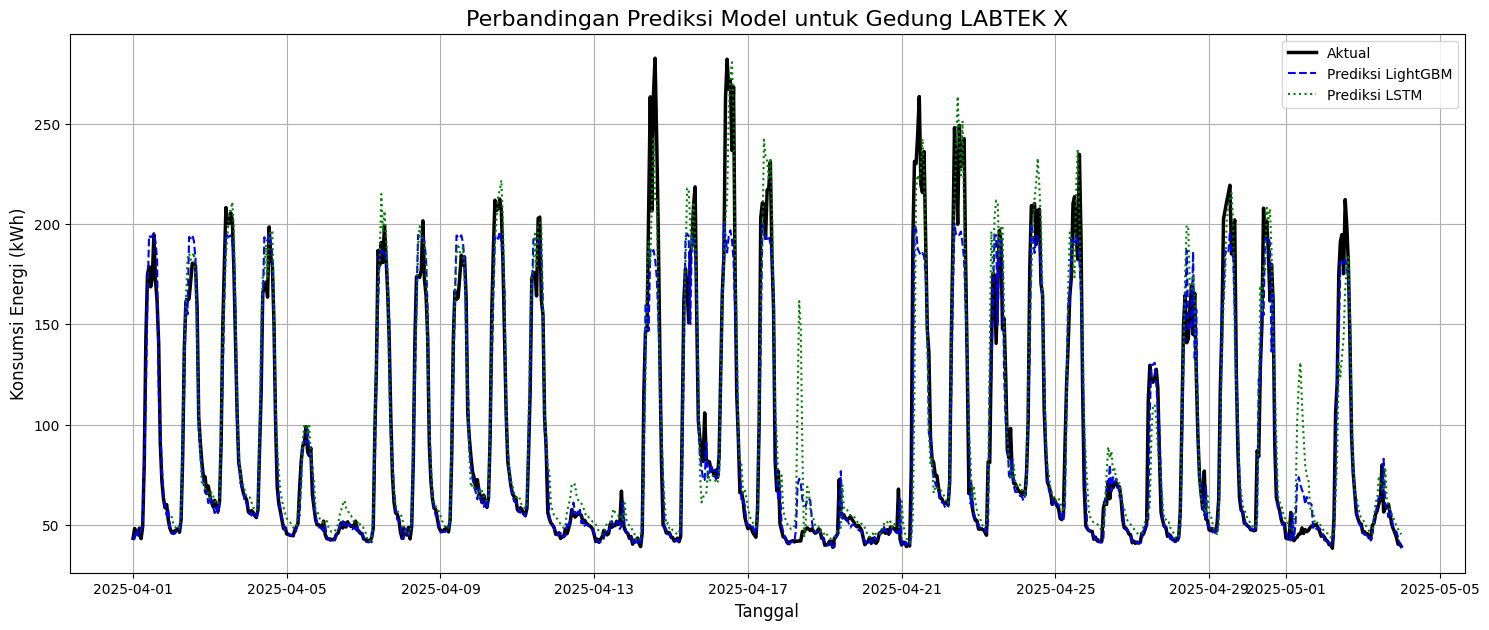

In [8]:
# --- PERUBAHAN DI SINI ---
def plot_perbandingan_model(df, meter_id, start_date, end_date):
    """
    Membuat plot perbandingan nilai aktual vs prediksi untuk satu gedung dalam rentang waktu tertentu.
    Fungsi ini sekarang lebih cerdas dalam menangani data LSTM yang mungkin kosong.
    """
    plot_data = df[
        (df['meter_id'] == meter_id) &
        (df['timestamp'] >= start_date) &
        (df['timestamp'] <= end_date)
    ]
    
    if plot_data.empty:
        print(f"Peringatan: Tidak ada data untuk gedung '{meter_id}' pada rentang tanggal yang dipilih.")
        return
    
    plt.figure(figsize=(18, 7))
    # Plot data aktual
    sns.lineplot(data=plot_data, x='timestamp', y='konsumsi_energi', label='Aktual', color='black', linewidth=2.5)
    # Plot prediksi LightGBM
    sns.lineplot(data=plot_data, x='timestamp', y='prediksi_lgbm', label='Prediksi LightGBM', color='blue', linestyle='--')
    
    # Cek apakah ada prediksi LSTM untuk diplot
    if not plot_data['prediksi_lstm'].isnull().all():
        sns.lineplot(data=plot_data, x='timestamp', y='prediksi_lstm', label='Prediksi LSTM', color='green', linestyle=':')
    else:
        print(f"Info: Prediksi LSTM tidak tersedia untuk gedung '{meter_id}' pada rentang waktu ini.")
    
    plt.title(f'Perbandingan Prediksi Model untuk Gedung {meter_id}', fontsize=16)
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('Konsumsi Energi (kWh)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

# Panggil fungsi untuk melihat perbandingan
# Anda bisa mengubah parameter ini
plot_perbandingan_model(df_compare, 
                        meter_id='LABTEK X', 
                        start_date='2025-04-01', 
                        end_date='2025-05-4')


# Analisis Error per Gedung (Analisis Spasial)

In [6]:
# --- PERUBAHAN DI SINI ---
# Hitung MAE per gedung untuk setiap model
mae_lgbm_per_gedung = df_compare_cleaned.groupby('meter_id').apply(lambda x: mean_absolute_error(x['konsumsi_energi'], x['prediksi_lgbm']))
mae_lstm_per_gedung = df_compare_cleaned.groupby('meter_id').apply(lambda x: mean_absolute_error(x['konsumsi_energi'], x['prediksi_lstm']))

# Gabungkan menjadi satu DataFrame
df_error_gedung = pd.DataFrame({
    'MAE_LightGBM': mae_lgbm_per_gedung,
    'MAE_LSTM': mae_lstm_per_gedung
})

# Tambahkan kolom untuk melihat model mana yang lebih baik untuk setiap gedung
df_error_gedung['Pemenang'] = np.where(df_error_gedung['MAE_LightGBM'] < df_error_gedung['MAE_LSTM'], 'LightGBM', 'LSTM')

# Beri informasi tentang gedung yang tidak muncul di tabel
gedung_total = set(df_compare['meter_id'].unique())
gedung_dibandingkan = set(df_error_gedung.index)
gedung_tidak_dibandingkan = gedung_total - gedung_dibandingkan

if gedung_tidak_dibandingkan:
    print("\nInformasi: Gedung berikut tidak dapat dibandingkan karena tidak memiliki prediksi dari kedua model:")
    print(gedung_tidak_dibandingkan)


print("\n--- Tabel Perbandingan Error (MAE) per Gedung ---")
print(df_error_gedung.sort_values(by='MAE_LSTM').round(2))



--- Tabel Perbandingan Error (MAE) per Gedung ---
                            MAE_LightGBM  MAE_LSTM  Pemenang
meter_id                                                    
Pompa Air - PAU                     0.03      0.15  LightGBM
Pompa Air - Sabuga                  0.07      0.28  LightGBM
Kantor FSRD                         0.22      0.30  LightGBM
PSDA                                0.21      0.32  LightGBM
LABTEK XI                           0.38      0.44  LightGBM
SBM MBA                             0.33      0.49  LightGBM
LAB. KONVERSI                       0.32      0.50  LightGBM
Gardu Konversi                      0.34      0.50  LightGBM
Kantor FTSL                         0.34      0.57  LightGBM
LABTEK VII                          0.56      0.70  LightGBM
Lab. Mekanika Fluida                0.36      0.75  LightGBM
Lab. PLN-ITB                        0.64      0.97  LightGBM
BSC A                               0.56      1.15  LightGBM
Gedung Teknik Lingkungan          

C:\Users\Danu Hakim\AppData\Local\Temp\ipykernel_2004\1660188610.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_lgbm_per_gedung = df_compare_cleaned.groupby('meter_id').apply(lambda x: mean_absolute_error(x['konsumsi_energi'], x['prediksi_lgbm']))
C:\Users\Danu Hakim\AppData\Local\Temp\ipykernel_2004\1660188610.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_lstm_per_gedung = df_compare_cle